## Topic classification using BERT Embeddings

In [1]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df = df_cleaned[~df_cleaned['issue'].str.contains(';')]
# selected_issues = [
#\t "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
# 				"National Security, Defence, Foreign Affairs", "Veterans and Military"
#   ]
print(df.groupby("issue")["text"].count())
threshold = 150
selected_issues = [k for k,v in dict(df.groupby("issue")["text"].count()).items() if v > threshold]
df = df[df['issue'].isin(selected_issues)]
df.groupby("issue")["text"].count()

issue
2nd Amendment and Gun Violence                  306
Agriculture                                     758
Constitution                                     26
Disaster Relief & Preparedness                   67
Education                                      1411
Energy and Environment                         2380
Equality and Civil Rights                       511
Federal Budget and Taxes                        667
Government and Law                             1015
Health Care and Social Security                2930
Housing                                         115
Infrastructure and Transportation               823
Jobs and the Economy                           2333
Local issues                                    750
National Security, Defence, Foreign Affairs    3673
Pro-Life/Abortion and Family Values             141
Science, Technology, & Telecommunications       337
Supporting Seniors                              146
Veterans and Military                          1376
Name: 

issue
2nd Amendment and Gun Violence                  306
Agriculture                                     758
Education                                      1411
Energy and Environment                         2380
Equality and Civil Rights                       511
Federal Budget and Taxes                        667
Government and Law                             1015
Health Care and Social Security                2930
Infrastructure and Transportation               823
Jobs and the Economy                           2333
Local issues                                    750
National Security, Defence, Foreign Affairs    3673
Science, Technology, & Telecommunications       337
Veterans and Military                          1376
Name: text, dtype: int64

In [2]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df.loc[:, "text"] = df["text"].apply(lambda text: preprocess_text(text, stopwords))
df = df[df["text"] != ""]

[nltk_data] Downloading package wordnet to /home/paulina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We want to use BERT solely for generating embeddings and then feed those embeddings into a separate neural network for classification, so we freeze the BERT model and use it as a feature extractor. This approach significantly reduces computational cost compared to fine-tuning the entire BERT model.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['issue'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = sbert_model.encode(train_texts.tolist(), convert_to_tensor=True)
val_embeddings = sbert_model.encode(val_texts.tolist(), convert_to_tensor=True)

train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)

train_dataset = TensorDataset(train_embeddings, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings, val_labels_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [4]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, model, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


def train(classifier, criterion, optimizer, train_loader, val_loader, epochs=30, patience=3, min_delta=10):
	if patience is None or min_delta is None:
		early_stopper = lambda x: False
	else:
		early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

	losses = []
	val_losses = []
	for epoch in range(epochs):  # Train for 10 epochs
					classifier.train()
					for batch in train_loader:
									optimizer.zero_grad()

									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									loss = criterion(outputs, labels)
									loss.backward()
									optimizer.step()
									

					final_loss = loss.item()
					classifier.eval()
					with torch.no_grad():
						for batch in val_loader:
							embeddings, labels = batch
							embeddings = embeddings.to(device)
							labels = labels.to(device).long()

							outputs = classifier(embeddings)
							val_loss = criterion(outputs, labels).item()
					print(f"Epoch {epoch + 1}, Loss: {final_loss}, Val loss: {val_loss}")
					losses.append(final_loss)
					val_losses.append(val_loss)
					if early_stopper.early_stop(classifier, val_loss):
						break
  
	if patience is not None and min_delta is not None:
		classifier.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

	return losses, val_losses

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
def evaluate(classifier, val_loader):
	classifier.eval()
	all_predictions = []
	all_labels = []
	with torch.no_grad():
					for batch in val_loader:
									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									predictions = torch.argmax(outputs, dim=-1)

									all_predictions.extend(predictions.cpu().numpy())
									all_labels.extend(labels.cpu().numpy())

	# Generate classification report
	print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

	# Generate confusion matrix
	cm = confusion_matrix(all_labels, all_predictions)
	cm_display_labels = label_encoder.classes_

	# Plot confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')
	plt.title('Confusion Matrix')
	plt.show()

---

## 6th model - smaller model with weighted loss and smaller lr

In [7]:
class Improved3NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved3NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

from sklearn.utils.class_weight import compute_class_weight
labels_tensor = torch.concat([train_labels_tensor, val_labels_tensor]) 
class_weights = compute_class_weight('balanced', classes=np.unique(labels_tensor), y=labels_tensor.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
print(class_weights)

model_improved6 = Improved3NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved6.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer_adam_im6 = torch.optim.Adam(model_improved6.parameters(), lr=5e-5, weight_decay=1e-6)

losses, val_losses = train(model_improved6, criterion_cros_entr_loss, optimizer_adam_im6, train_loader, val_loader, 600, patience=3, min_delta=2)

tensor([4.4981, 1.8159, 0.9755, 0.5783, 2.6936, 2.0636, 1.3561, 0.4698, 1.6725,
        0.5900, 1.8352, 0.3747, 4.0844, 1.0003])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_CUDA_nll_loss_forward)

                                             precision    recall  f1-score   support

             2nd Amendment and Gun Violence       0.78      0.85      0.81        61
                                Agriculture       0.78      0.86      0.82       152
                                  Education       0.81      0.80      0.81       282
                     Energy and Environment       0.84      0.82      0.83       476
                  Equality and Civil Rights       0.71      0.71      0.71       102
                   Federal Budget and Taxes       0.62      0.65      0.63       133
                         Government and Law       0.60      0.67      0.63       203
            Health Care and Social Security       0.91      0.85      0.88       586
          Infrastructure and Transportation       0.68      0.79      0.73       165
                       Jobs and the Economy       0.71      0.70      0.70       467
                               Local issues       0.66      0.67

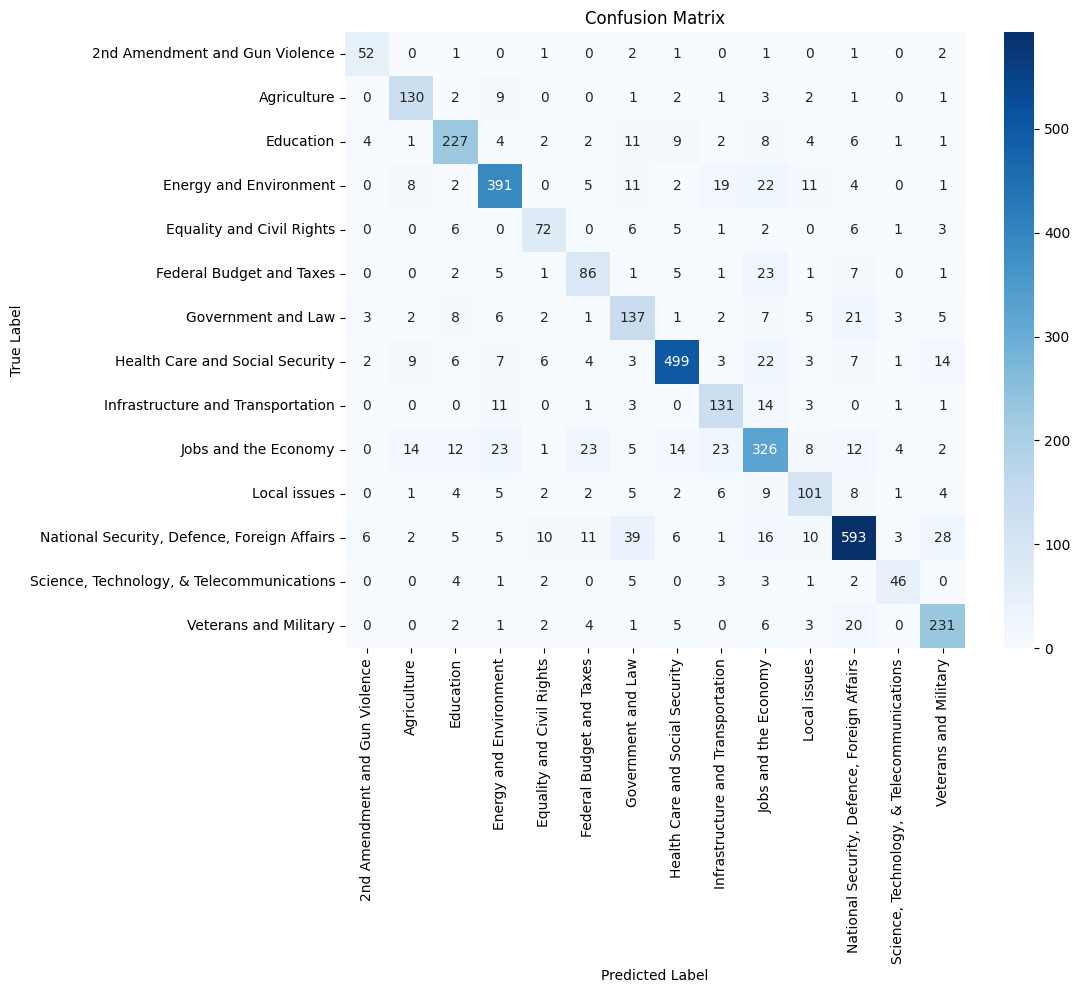

In [ ]:
evaluate(model_improved6, val_loader)

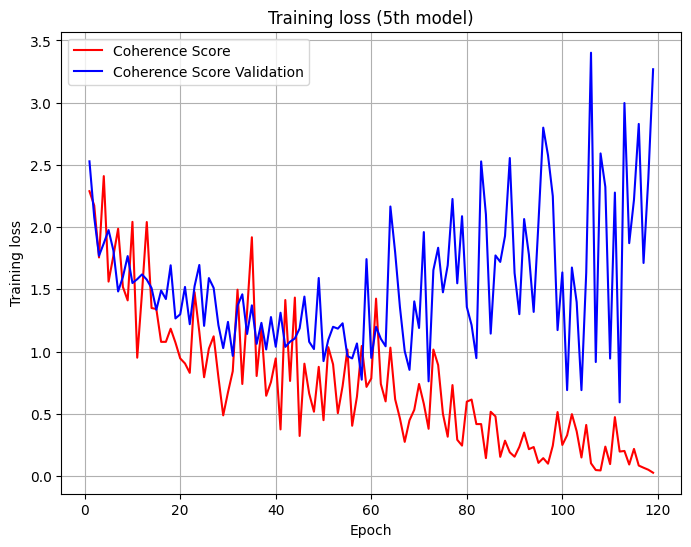

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, linestyle='-', color='r', label='Coherence Score')
plt.plot(list(range(1, len(val_losses)+1)), val_losses, linestyle='-', color='b', label='Coherence Score Validation')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (5th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

---

## 7th model - even smaller model

In [69]:
class Improved7NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved7NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

from sklearn.utils.class_weight import compute_class_weight
labels_tensor = torch.concat([train_labels_tensor, val_labels_tensor]) 
class_weights = compute_class_weight('balanced', classes=np.unique(labels_tensor), y=labels_tensor.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
print(class_weights)

model_improved7 = Improved7NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved7.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer_adam_im7 = torch.optim.Adam(model_improved7.parameters(), lr=1e-4, weight_decay=1e-4)

losses, val_losses = train(model_improved7, criterion_cros_entr_loss, optimizer_adam_im7, train_loader, val_loader, 300, patience=3, min_delta=2)

tensor([4.4981, 1.8159, 0.9755, 0.5783, 2.6936, 2.0636, 1.3561, 0.4698, 1.6725,
        0.5900, 1.8352, 0.3747, 4.0844, 1.0003])
Epoch 1, Loss: 2.4590718746185303, Val loss: 2.4696195125579834
Epoch 2, Loss: 2.0353615283966064, Val loss: 1.802847146987915
Epoch 3, Loss: 1.5278606414794922, Val loss: 1.638981580734253
Epoch 4, Loss: 1.756700038909912, Val loss: 1.5544239282608032
Epoch 5, Loss: 1.6800439357757568, Val loss: 1.5057858228683472
Epoch 6, Loss: 2.208693265914917, Val loss: 1.4361990690231323
Epoch 7, Loss: 1.2080081701278687, Val loss: 1.3561962842941284
Epoch 8, Loss: 1.4918831586837769, Val loss: 1.379852533340454
Epoch 9, Loss: 1.177573800086975, Val loss: 1.3898565769195557
Epoch 10, Loss: 0.7862464189529419, Val loss: 1.3094474077224731
Epoch 11, Loss: 1.0952494144439697, Val loss: 1.3127306699752808
Epoch 12, Loss: 0.6787564754486084, Val loss: 1.2838830947875977
Epoch 13, Loss: 0.8607472777366638, Val loss: 1.3153162002563477
Epoch 14, Loss: 1.2042675018310547, Val l

                                             precision    recall  f1-score   support

             2nd Amendment and Gun Violence       0.82      0.89      0.85        61
                                Agriculture       0.85      0.80      0.82       152
                                  Education       0.82      0.87      0.84       282
                     Energy and Environment       0.87      0.82      0.85       476
                  Equality and Civil Rights       0.69      0.71      0.70       102
                   Federal Budget and Taxes       0.62      0.65      0.64       133
                         Government and Law       0.80      0.60      0.68       203
            Health Care and Social Security       0.88      0.88      0.88       586
          Infrastructure and Transportation       0.75      0.82      0.78       165
                       Jobs and the Economy       0.69      0.78      0.73       467
                               Local issues       0.72      0.68

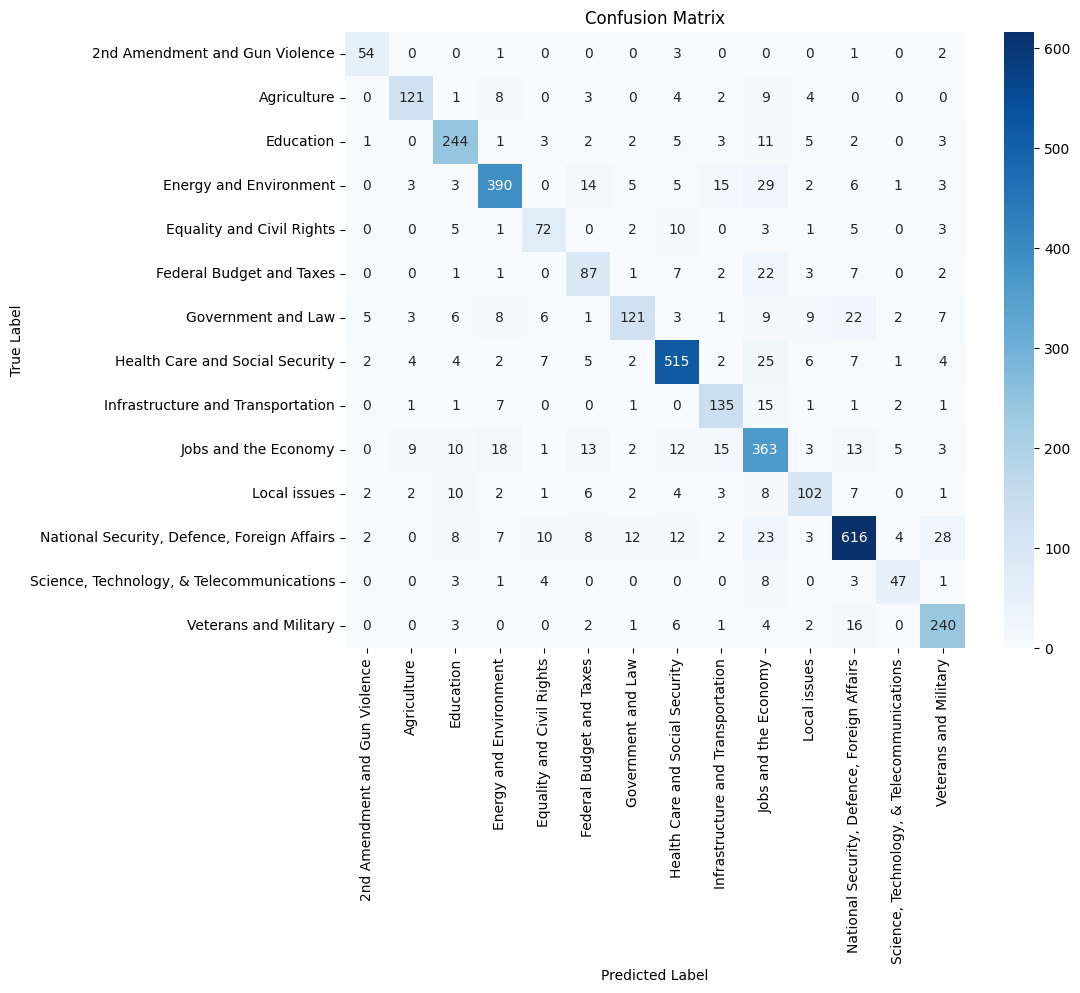

In [72]:
evaluate(model_improved7, val_loader)

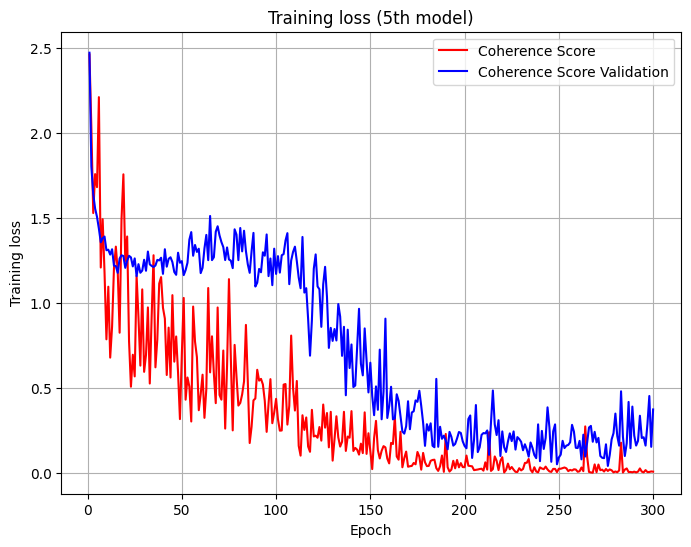

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, linestyle='-', color='r', label='Coherence Score')
plt.plot(list(range(1, len(val_losses)+1)), val_losses, linestyle='-', color='b', label='Coherence Score Validation')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (5th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

---

## 8th model - 7th model 11 classes

In [48]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df = df_cleaned[~df_cleaned['issue'].str.contains(';')]
# selected_issues = [
#\t "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
# 				"National Security, Defence, Foreign Affairs", "Veterans and Military"
#   ]
print(df.groupby("issue")["text"].count())
threshold = 700
selected_issues = [k for k,v in dict(df.groupby("issue")["text"].count()).items() if v > threshold]
df = df[df['issue'].isin(selected_issues)]
df.groupby("issue")["text"].count()

issue
2nd Amendment and Gun Violence                  306
Agriculture                                     758
Constitution                                     26
Disaster Relief & Preparedness                   67
Education                                      1411
Energy and Environment                         2380
Equality and Civil Rights                       511
Federal Budget and Taxes                        667
Government and Law                             1015
Health Care and Social Security                2930
Housing                                         115
Infrastructure and Transportation               823
Jobs and the Economy                           2333
Local issues                                    750
National Security, Defence, Foreign Affairs    3673
Pro-Life/Abortion and Family Values             141
Science, Technology, & Telecommunications       337
Supporting Seniors                              146
Veterans and Military                          1376
Name: 

issue
Agriculture                                     758
Education                                      1411
Energy and Environment                         2380
Government and Law                             1015
Health Care and Social Security                2930
Infrastructure and Transportation               823
Jobs and the Economy                           2333
Local issues                                    750
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [49]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df.loc[:, "text"] = df["text"].apply(lambda text: preprocess_text(text, stopwords))
df = df[df["text"] != ""]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['issue'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = sbert_model.encode(train_texts.tolist(), convert_to_tensor=True)
val_embeddings = sbert_model.encode(val_texts.tolist(), convert_to_tensor=True)

train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)

train_dataset = TensorDataset(train_embeddings, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings, val_labels_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [59]:
class Improved8NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved8NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

from sklearn.utils.class_weight import compute_class_weight
labels_tensor = torch.concat([train_labels_tensor, val_labels_tensor]) 
class_weights = compute_class_weight('balanced', classes=np.unique(labels_tensor), y=labels_tensor.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
print(class_weights)

model_improved8 = Improved8NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved8.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer_adam_im8 = torch.optim.Adam(model_improved8.parameters(), lr=1e-4, weight_decay=1e-4)

losses, val_losses = train(model_improved8, criterion_cros_entr_loss, optimizer_adam_im8, train_loader, val_loader, 300, patience=3, min_delta=2)

tensor([2.3020, 1.2366, 0.7332, 1.7191, 0.5955, 2.1202, 0.7479, 2.3265, 0.4751,
        1.2681])
Epoch 1, Loss: 2.0172977447509766, Val loss: 1.4583691358566284
Epoch 2, Loss: 1.0926434993743896, Val loss: 0.8395184278488159
Epoch 3, Loss: 1.4243910312652588, Val loss: 0.7204985618591309
Epoch 4, Loss: 1.1214321851730347, Val loss: 0.630893886089325
Epoch 5, Loss: 1.5654726028442383, Val loss: 0.606395959854126
Epoch 6, Loss: 1.9470056295394897, Val loss: 0.41219234466552734
Epoch 7, Loss: 1.5906099081039429, Val loss: 0.6024313569068909
Epoch 8, Loss: 1.817643642425537, Val loss: 0.2127639800310135
Epoch 9, Loss: 0.7445546984672546, Val loss: 0.3930365741252899
Epoch 10, Loss: 1.914656162261963, Val loss: 0.5354304313659668
Epoch 11, Loss: 1.8377325534820557, Val loss: 0.30365845561027527
Epoch 12, Loss: 1.8404569625854492, Val loss: 0.4672493040561676
Epoch 13, Loss: 0.2758023738861084, Val loss: 0.20769478380680084
Epoch 14, Loss: 1.620572805404663, Val loss: 0.42310652136802673
Epo

                                             precision    recall  f1-score   support

                                Agriculture       0.82      0.79      0.81       151
                                  Education       0.86      0.80      0.83       282
                     Energy and Environment       0.85      0.87      0.86       476
                         Government and Law       0.67      0.63      0.65       203
            Health Care and Social Security       0.92      0.87      0.89       586
          Infrastructure and Transportation       0.70      0.68      0.69       165
                       Jobs and the Economy       0.75      0.79      0.77       467
                               Local issues       0.65      0.67      0.66       150
National Security, Defence, Foreign Affairs       0.86      0.87      0.86       735
                      Veterans and Military       0.80      0.83      0.81       275

                                   accuracy                    

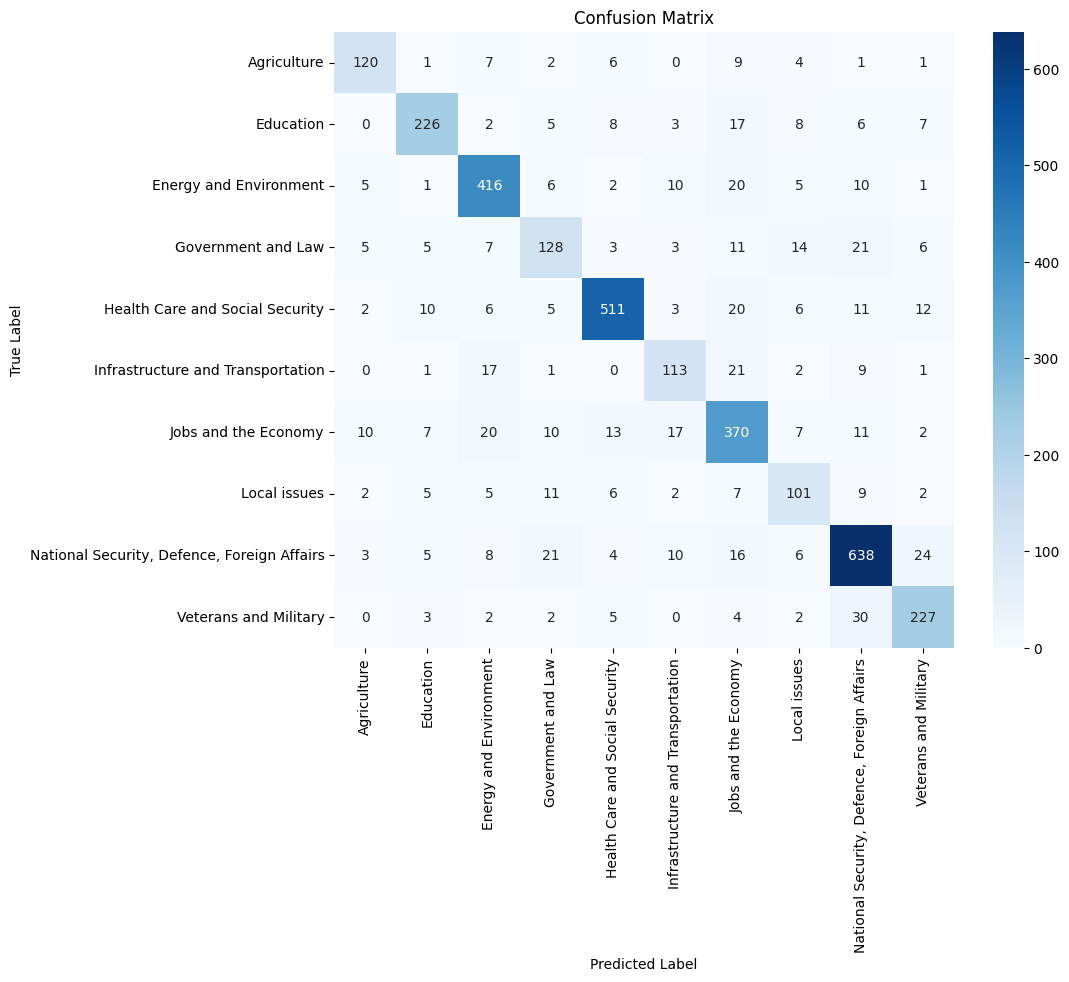

In [61]:
evaluate(model_improved8, val_loader)

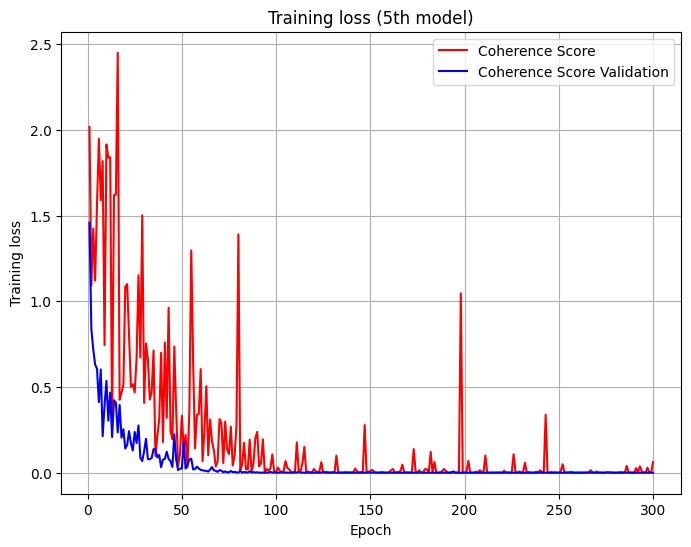

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, linestyle='-', color='r', label='Coherence Score')
plt.plot(list(range(1, len(val_losses)+1)), val_losses, linestyle='-', color='b', label='Coherence Score Validation')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (5th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()